In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
df = pd.read_csv("Dataset_spine.csv")
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att,Unnamed: 13
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal,NaN
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal,NaN
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal,Prediction is done by using binary classificat...
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal,NaN
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal,NaN


<AxesSubplot:xlabel='Class_att', ylabel='count'>

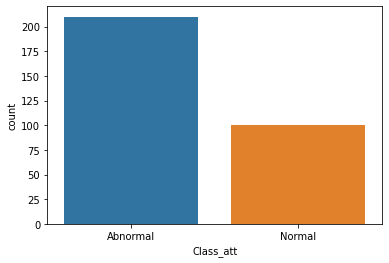

In [4]:
sns.countplot(x = 'Class_att', data=df)

In [68]:
df['Class_att'] = df['Class_att'].astype('category')
encode_map = {
    'Abnormal': 1,
    'Normal': 0
}

df['Class_att'].replace(encode_map, inplace=True)

In [69]:
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att,Unnamed: 13
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,1,NaN
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,1,NaN
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,1,Prediction is done by using binary classificat...
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,1,NaN
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,1,NaN


In [77]:
X = df.iloc[:, 0:-2]
y = df.iloc[:, -2]

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [80]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [81]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [82]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [83]:
for x, y in train_loader:
    print(x.shape)

torch.Size([64, 12])
torch.Size([64, 12])
torch.Size([64, 12])
torch.Size([15, 12])


In [84]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(12, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [85]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [86]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=12, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [53]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [98]:
y_pred.shape

torch.Size([15, 1])

In [97]:
y_batch.shape

torch.Size([15])

In [94]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.03752 | Acc: 97.750
Epoch 002: | Loss: 0.01209 | Acc: 100.000
Epoch 003: | Loss: 0.01451 | Acc: 100.000
Epoch 004: | Loss: 0.00940 | Acc: 100.000
Epoch 005: | Loss: 0.01991 | Acc: 100.000
Epoch 006: | Loss: 0.01352 | Acc: 100.000
Epoch 007: | Loss: 0.00686 | Acc: 100.000
Epoch 008: | Loss: 0.01655 | Acc: 100.000
Epoch 009: | Loss: 0.01150 | Acc: 100.000
Epoch 010: | Loss: 0.02397 | Acc: 98.250
Epoch 011: | Loss: 0.00738 | Acc: 100.000
Epoch 012: | Loss: 0.00774 | Acc: 100.000
Epoch 013: | Loss: 0.06633 | Acc: 98.250
Epoch 014: | Loss: 0.00733 | Acc: 100.000
Epoch 015: | Loss: 0.06143 | Acc: 98.250
Epoch 016: | Loss: 0.01340 | Acc: 100.000
Epoch 017: | Loss: 0.01932 | Acc: 100.000
Epoch 018: | Loss: 0.02116 | Acc: 100.000
Epoch 019: | Loss: 0.01646 | Acc: 100.000
Epoch 020: | Loss: 0.01973 | Acc: 100.000
Epoch 021: | Loss: 0.00953 | Acc: 100.000
Epoch 022: | Loss: 0.00438 | Acc: 100.000
Epoch 023: | Loss: 0.00682 | Acc: 100.000
Epoch 024: | Loss: 0.08388 | Acc: 95.0

In [89]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [90]:
confusion_matrix(y_test, y_pred_list)

array([[21, 10],
       [10, 62]], dtype=int64)